In [2]:
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from tqdm.notebook import tqdm  # Import tqdm for progress bar
import seaborn as sns
from myMLlib import set_seed, load_data_list, rebalance_weight, plt_loss, plt_confusion, DEIM, layer_activation


In [3]:
folderpath= ('/Users/stonyxiong/files/research/dataset/New_bloodmeat_fra5_right',
             '/Users/stonyxiong/files/research/dataset/New_bloodmeat_fra6_left',
             '/Users/stonyxiong/files/research/dataset/New_bloodmeat_fra7_left')


materials = ['blood','meat']
realmater = ['Silicone/Water','Silicone']
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 14
})

In [4]:
frequency_vec = pd.read_csv(f'{folderpath[0]}/frequency_vector.csv').values
data_list,labels = load_data_list(folderpath,materials,[3e4,1.5e4,3e4])

In [5]:
set_seed(40)
snapshot = np.array(data_list[0]+data_list[2]).squeeze()
y = np.array(labels[0]+ labels[2]).reshape(-1,1)
snapshot_r = np.array(data_list[1]).squeeze()
y_r = np.array(labels[1]).reshape(-1,1)
print(snapshot.shape)
print(y.shape)
print(snapshot_r.shape)
print(y_r.shape)


(59999, 512)
(59999, 1)
(14999, 512)
(14999, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

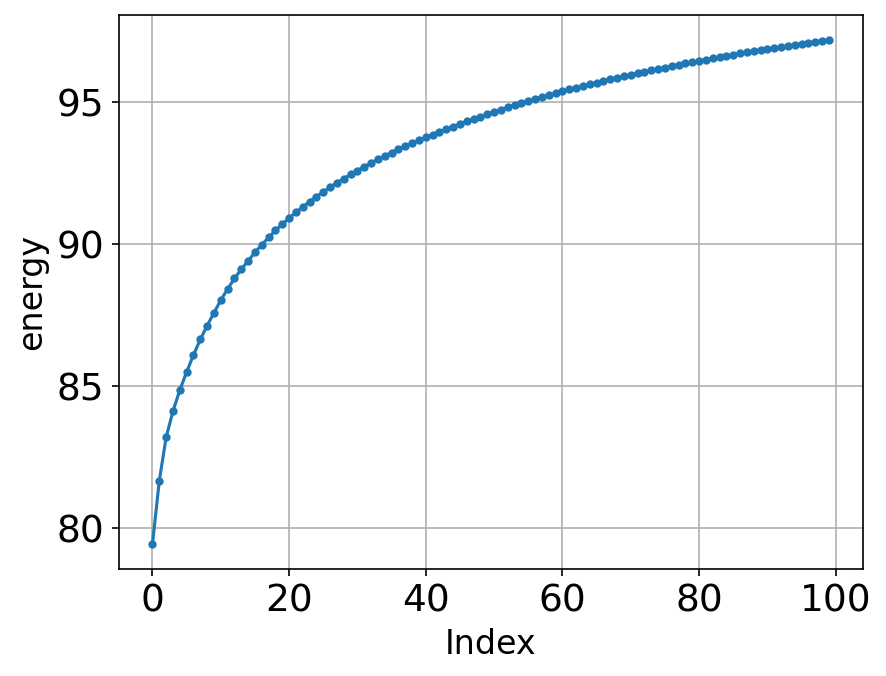

In [6]:
snapshot_train, snapshot_test, y_train, y_test = train_test_split(snapshot, y, test_size=0.001, random_state=47)
U,S,Vt = np.linalg.svd(snapshot_train,full_matrices=False)
V = Vt.T
energy = np.cumsum(S)/np.sum(S)*100
plt.figure(dpi=150)
plt.plot(energy[0:100],marker = 'o',linestyle='-',markersize = 3)
plt.xlabel('Index')
plt.ylabel('energy')
plt.grid(True)
plt.show

In [7]:
Vr = V[:,:16]
points = DEIM(Vr)
Xp_train = snapshot_train[:,points]
Xp_test = snapshot_test[:,points]
Xp_r = snapshot_r[:,points]
joblib.dump(points,'/Users/stonyxiong/files/Research/models/bloodmeat_fre_points.save')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

['/Users/stonyxiong/files/Research/models/bloodmeat_fre_points.save']

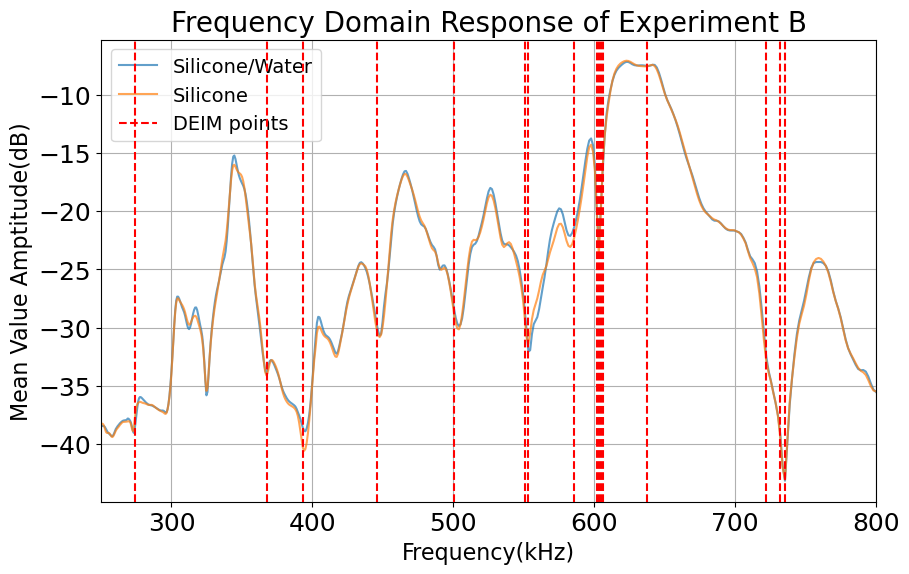

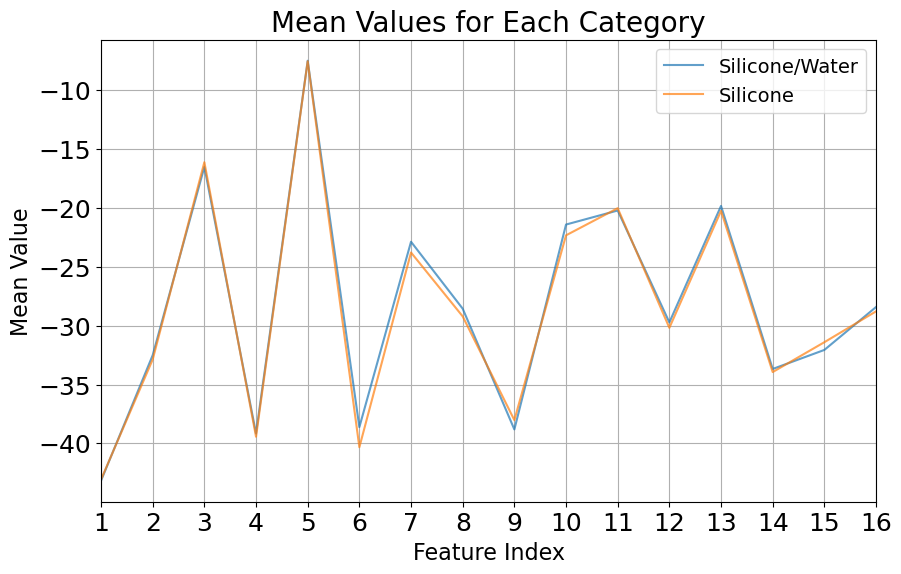

<Figure size 1000x600 with 0 Axes>

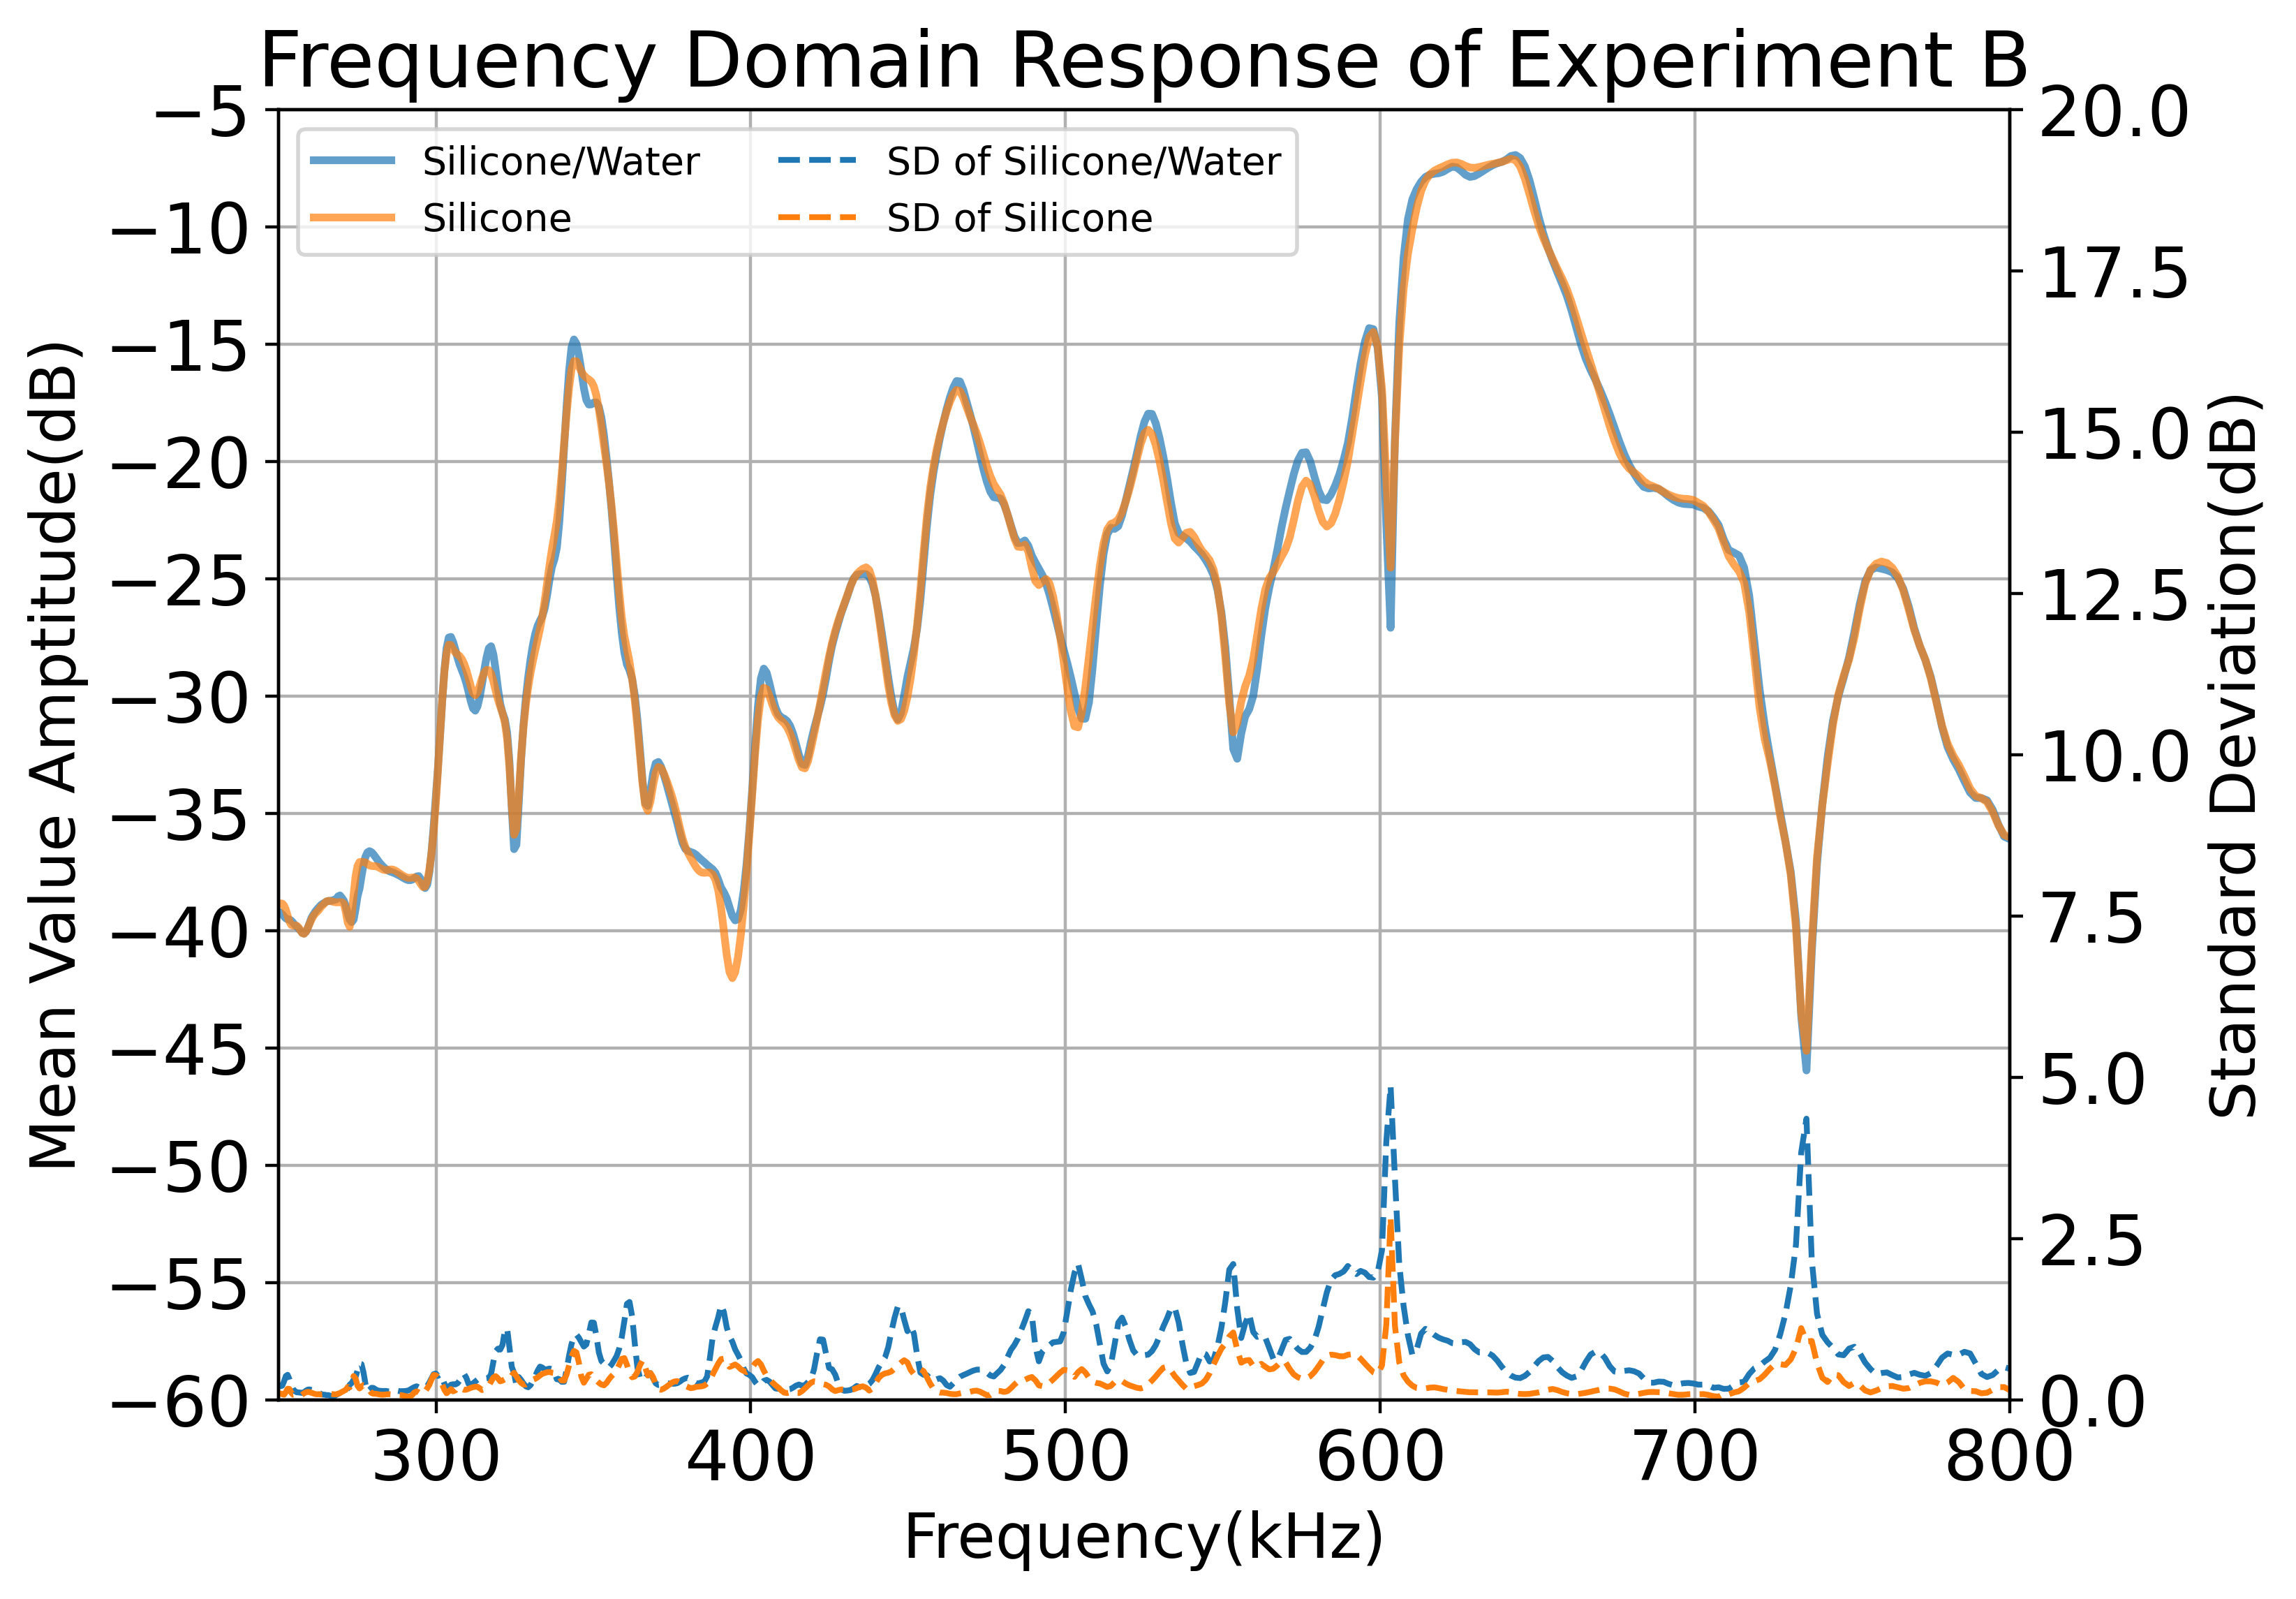

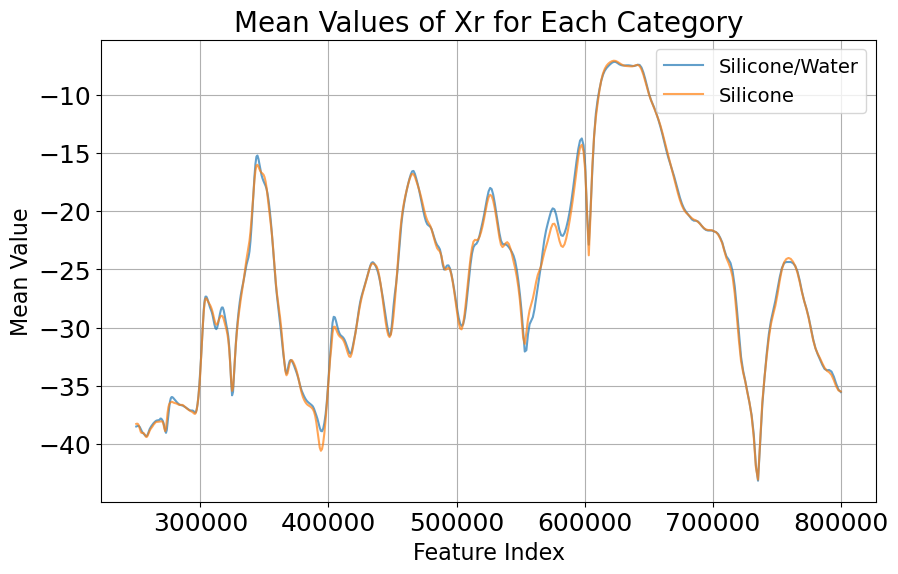

In [31]:
unique_labels = np.unique(y_train)
indices1 = {}
indices2 = {}
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = snapshot_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(frequency_vec/1e3,mean_values, label=f"{realmater[int(label)]}",alpha = 0.7)
for i, value in enumerate(frequency_vec[points] / 1e3):  # 转成 kHz
    plt.axvline(x=value, color='red', linestyle='--',
                label='DEIM points' if i == 0 else None, zorder=10)
plt.xlim([250, 800])
plt.xlabel("Frequency(kHz)")
plt.ylabel("Mean Value Amptitude(dB)")
plt.title("Frequency Domain Response of Experiment B")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = Xp_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(range(1,mean_values.shape[0]+1),mean_values, label=f"{realmater[int(label)]}",alpha = 0.7)
plt.xlim([1, 16])
plt.xticks(range(1, 17))  # 横坐标每个整数都显示
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
# std_values = {}
# plt.figure(figsize=(8,6),dpi = 400)
# for i,label in enumerate(unique_labels):
#     # 获取当前类别下的样本索引
#     indices2[materials[i]] = np.where(y_r.flatten() == label)
#     # 计算当前类别 X 中所有样本的特征均值（按列均值）
#     mean_values = snapshot_r[indices2[materials[i]]].mean(axis=0) # type: ignore
#     # 绘制均值曲线
#     std_values[label] = snapshot_r[indices2[materials[i]]].std(axis=0)
#     plt.plot(frequency_vec/1e3,mean_values, label=f"{realmater[i]}",alpha = 0.7,linewidth = 2)
#     plt.plot(frequency_vec/1e3,std_values[label], label = f"SD of {realmater[i]}")
# plt.xlabel("Frequency(kHz)")
# plt.ylabel("Mean Value Amptitude(dB)")
# plt.title("Frequency Domain Response of Experiment B")
# plt.xticks(np.unique(np.append(plt.xticks()[0], 250)))
# plt.xlim([250,800])
# plt.legend(fontsize = 10)
# plt.grid(True)
# plt.savefig("/Users/stonyxiong/files/Research/figures/ExpBfre-sign.pdf", format="pdf", bbox_inches="tight")
# plt.show()
fig, ax1 = plt.subplots(figsize=(8,6), dpi=400)
ax2 = ax1.twinx()  # 创建一个共享 x 轴的右侧纵坐标

for i, label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_r.flatten() == label)
    # 计算均值和标准差（按列统计）
    mean_values = snapshot_r[indices2[materials[i]]].mean(axis=0)  # type: ignore
    std_vals = snapshot_r[indices2[materials[i]]].std(axis=0)
    # 在左侧坐标系绘制均值曲线
    ax1.plot(frequency_vec/1e3, mean_values, label=f"{realmater[i]}", alpha=0.7, linewidth=2)
    # 在右侧坐标系绘制标准差曲线
    ax2.plot(frequency_vec/1e3, std_vals, label=f"SD of {realmater[i]}", linestyle='--')

ax1.set_xlabel("Frequency(kHz)")
ax1.set_ylabel("Mean Value Amptitude(dB)")
ax2.set_ylabel("Standard Deviation(dB)")
ax2.set_ylim([0,20])
yticks = np.arange(-65, -4, 5)  # 上限为 -4 以确保包含 -5
ax1.set_yticks(yticks)
ax1.set_ylim([-60,-5])
ax1.set_title("Frequency Domain Response of Experiment B")
ax1.set_xlim([250,800])
ax1.grid(True)

# 合并左右坐标系中的图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='best',ncol = 2)
plt.savefig("/Users/stonyxiong/files/Research/figures/ExpBfre-sign.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = snapshot_train[indices1[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(frequency_vec,mean_values, label=f"{realmater[i]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: mps


In [13]:
# Split data into train and test sets
scaler = StandardScaler()
X_train = scaler.fit_transform(Xp_train)
X_test = scaler.transform(Xp_test)
X_r_test = scaler.transform(Xp_r)
joblib.dump(scaler,'/Users/stonyxiong/files/Research/models/bloodmeat_fre_scaler.save')

scaler = MinMaxScaler(feature_range=(0, len(materials)-1))
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_r_test = scaler.transform(y_r)

X_r_ver,X_r_te, y_r_ver, y_r_te = train_test_split(X_r_test, y_r_test, train_size = 0.3,random_state=42)

print(X_r_ver.shape)
print(X_r_te.shape)


(4499, 16)
(10500, 16)


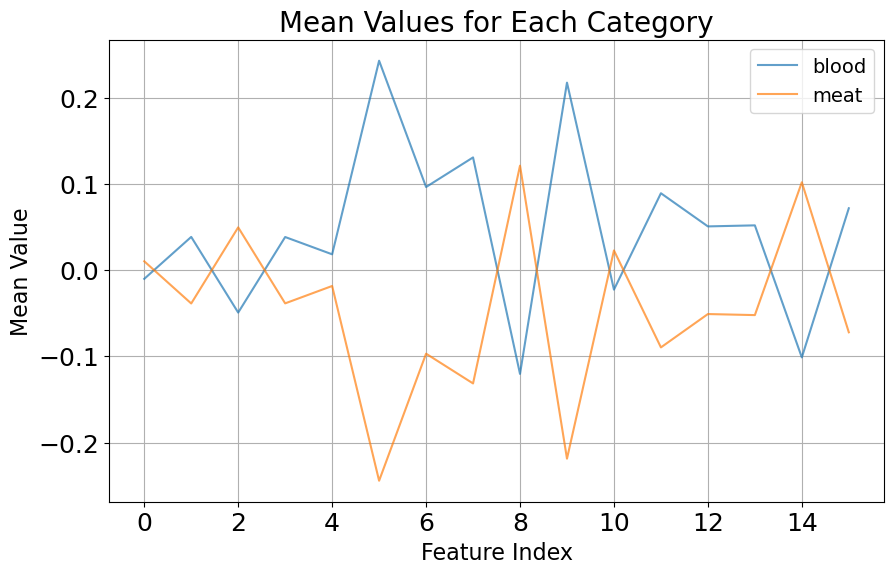

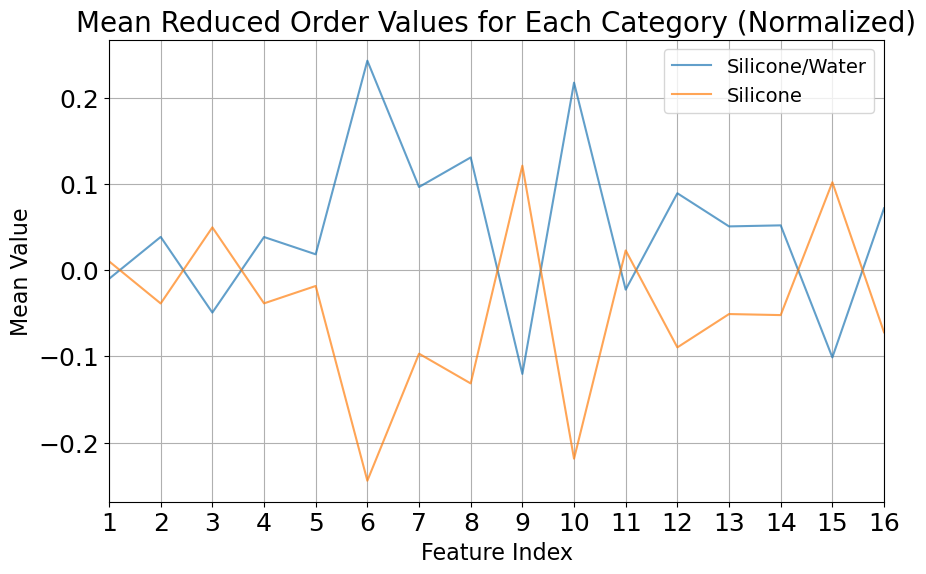

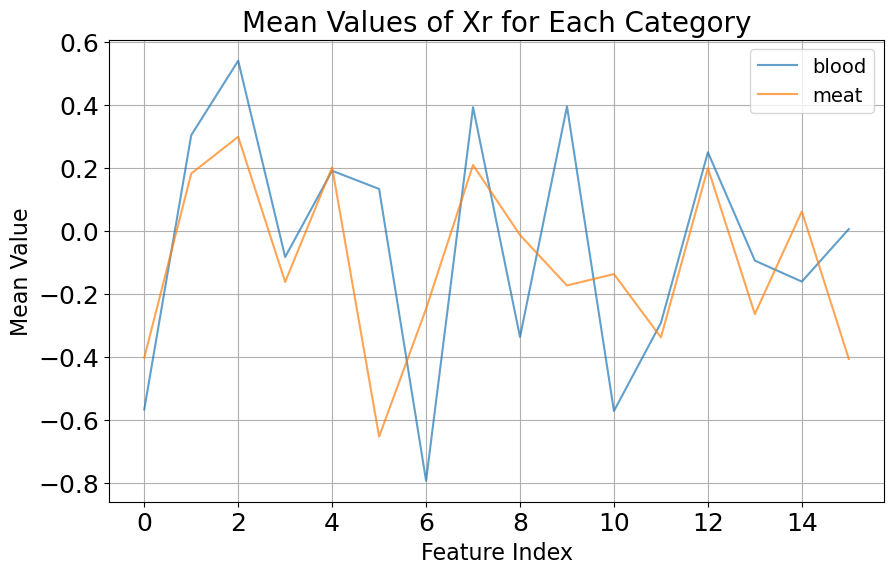

In [33]:
indices1 = {}
indices2 = {}
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(range(1,mean_values.shape[0]+1),mean_values, label=f"{realmater[int(label)]}",alpha = 0.7)
plt.xlim([1, 16])
plt.xticks(range(1, 17))  # 横坐标每个整数都显示
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Reduced Order Values for Each Category (Normalized)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_r_te.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_r_te[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[i]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)
plt.show()



In [15]:
class ANN_Model(nn.Module):

    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 16)
        self.fc2 = nn.Linear(16, 14)
        self.fc3 = nn.Linear(14, 8)
        self.fc4 = nn.Linear(8, len(materials))

        self.act = nn.ELU()


    def forward(self, i):
        h1 = self.act(self.fc1(i))
        h2 = self.act(self.fc2(h1))
        h3 = self.act(self.fc3(h2))
        o = self.fc4(h3)
        return o

set_seed(40)

In [16]:
model = ANN_Model().to(device)

class_weights,_ = rebalance_weight(y_train)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=2e-5,weight_decay=1e-4)
# 4. 将 numpy 数据转为 torch 张量并移动到 device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).squeeze().to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).squeeze().to(device)
X_r_ver_tensor = torch.tensor(X_r_ver, dtype=torch.float32).to(device)
y_r_ver_tensor = torch.tensor(y_r_ver,dtype=torch.long).squeeze().to(device)
X_r_te_tensor = torch.tensor(X_r_te, dtype = torch.float32).to(device)
y_r_te_tensor = torch.tensor(y_r_te,dtype=torch.long).squeeze().to(device)

In [17]:
# 5. 训练模型
num_epochs = 24000
train_losses = []
verify_losses = []
lossthreshold = 0.001
pbar = tqdm(range(num_epochs), desc="Training", leave=True)
for epoch in pbar:
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # —— 2. 验证 —— #
    model.eval()
    with torch.no_grad():
        verify_outputs = model(X_r_ver_tensor)    
        verify_loss = criterion(verify_outputs, y_r_ver_tensor)
        verify_losses.append(verify_loss.item())
    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(train_loss=loss.item(), verify_loss=verify_loss.item())
    if loss < lossthreshold:
        break

Training:   0%|          | 0/24000 [00:00<?, ?it/s]

In [18]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_test, predicted_np)
    cm = confusion_matrix(y_test, predicted_np)

Accuracy: 1.0
Accuracy_train: 0.9989989822986703
Confusion Matrix:
[[30  0]
 [ 0 30]]


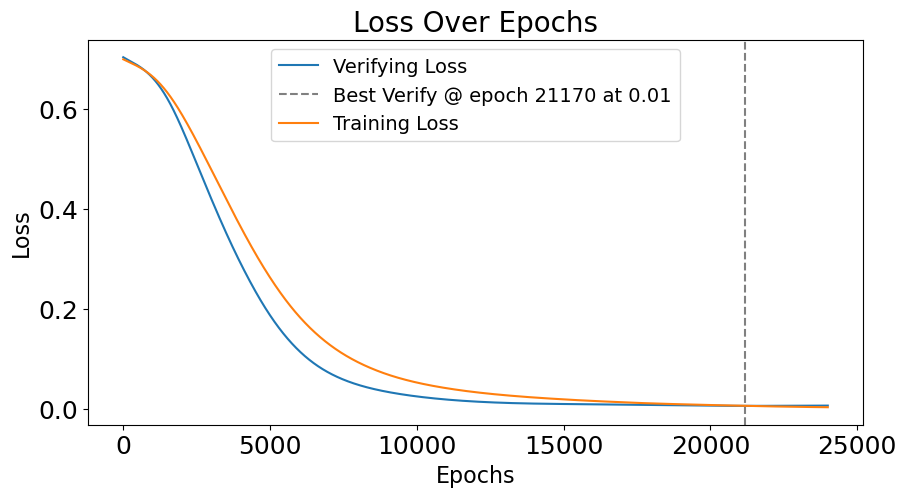

In [19]:
print(f'Accuracy: {accuracy}')
print(f'Accuracy_train: {accuracy_train}')
print(f'Confusion Matrix:\n{cm}')

plt_loss(train_losses=train_losses, verifying_losses =verify_losses)

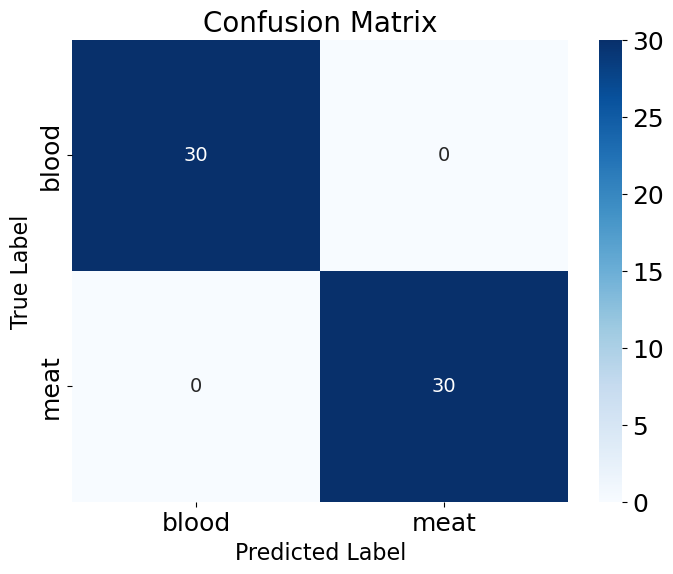

Accuracy: 1.0
              precision    recall  f1-score   support

       blood       1.00      1.00      1.00        30
        meat       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [20]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=materials,
            yticklabels=materials)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

# Convert y_test to integer labels
y_test_int = y_test.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np,
                               target_names=materials, labels=range(len(materials)))
print("Accuracy:", accuracy)
print(report)

In [21]:
model.eval()
with torch.no_grad():
    r_ver_outputs = model(X_r_ver_tensor)
    _, predicted = torch.max(r_ver_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    ver_accuracy = accuracy_score(y_r_ver, predicted_np)
    ver_cm = confusion_matrix(y_r_ver, predicted_np)

Accuracy: 0.9964436541453656


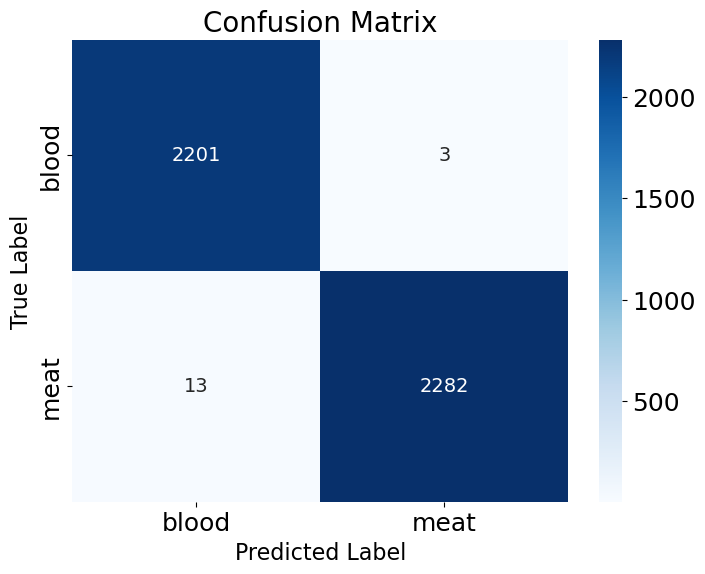

In [22]:
print(f'Accuracy: {ver_accuracy}')
plt_confusion(ver_cm,materials)

In [23]:
model.eval()
with torch.no_grad():
    r_te_outputs = model(X_r_te_tensor)
    _, predicted = torch.max(r_te_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    r_accuracy = accuracy_score(y_r_te, predicted_np)
    r_cm = confusion_matrix(y_r_te, predicted_np)

Accuracy: 0.9964761904761905


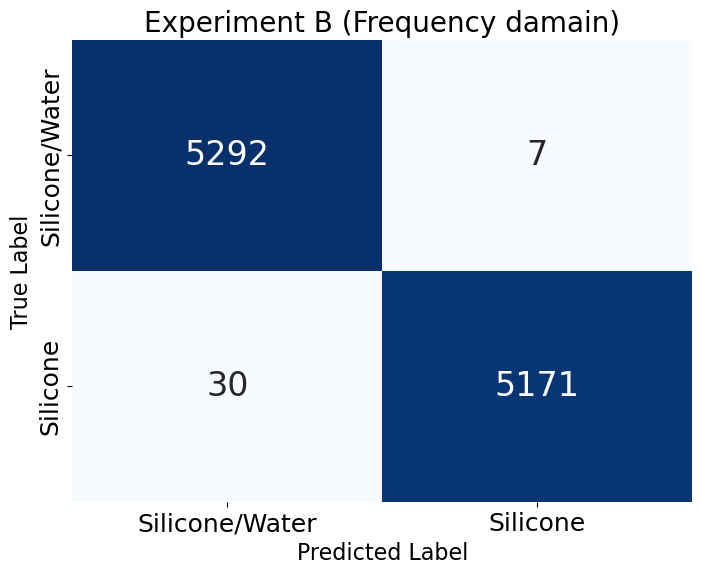

In [24]:
print(f'Accuracy: {r_accuracy}')
plt.figure(figsize=(8,6))
sns.heatmap(
    r_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=realmater,
    yticklabels=realmater,
    annot_kws={"size": 24}  # 设置数字字体大小
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Experiment B (Frequency damain)")
plt.xticks()
plt.yticks()
# plt.savefig("/Users/stonyxiong/files/Research/figures/ExpB-fre.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [25]:
model.eval()
with torch.no_grad():
    logits = model(X_r_te_tensor.to(device))    # [N,2]
    
    # 方法 A：用 softmax 概率
    probs = torch.softmax(logits, dim=1)           # [N, 2]
    all_scores = probs[:, 1].cpu().numpy()         # 正类概率 ∈ [0,1]
    all_labels = y_r_te  # shape (N,)

In [26]:
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = roc_auc_score(all_labels, all_scores)

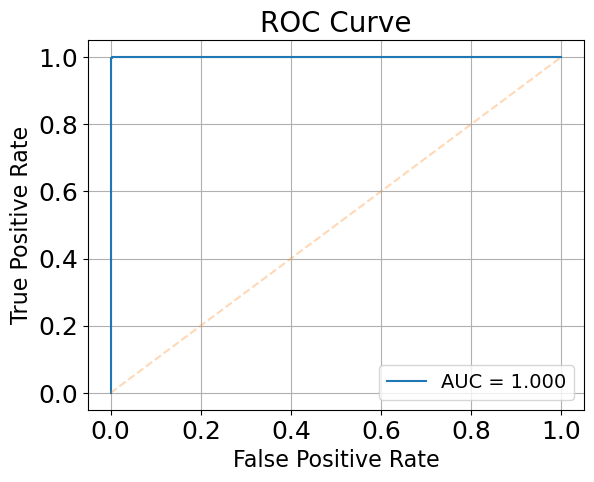

In [27]:
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', alpha=0.3)   # 对角参考线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

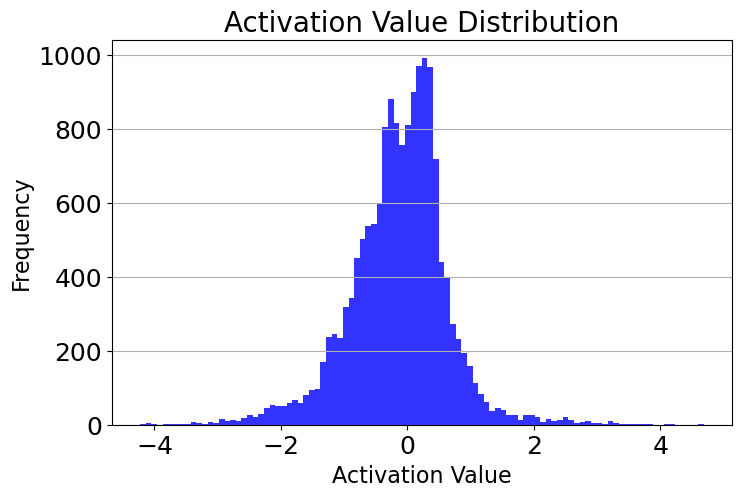

16000


In [28]:
actives = layer_activation(model=model, device=device, fclayer='fc1', data=X_r_te[:1000, :])
# Replace 'fc1' with the correct key if you want another layer
actives
plt.figure(figsize=(8, 5))
plt.hist(actives.flatten(), bins=100, color='blue', alpha=0.8)
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.title("Activation Value Distribution")
plt.grid(True, axis='y')
plt.show()
print(len(actives.flatten()))

In [29]:
save_dir = '/Users/stonyxiong/files/Research/models'
save_path = os.path.join(save_dir, 'bloodmeat_fredomain.pth')
torch.jit.script(model).save(save_path)